# Spiral ODE

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/Crown421/GPDiffEq.jl/blob/main/examples/spiral/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/spiral/).*

## Setup

Load necessary packages

In [1]:
using Plots
using LinearAlgebra
using GPDiffEq
using Optimization, OptimizationOptimJL
using Zygote

First we define an ODE and generate some data points from it.

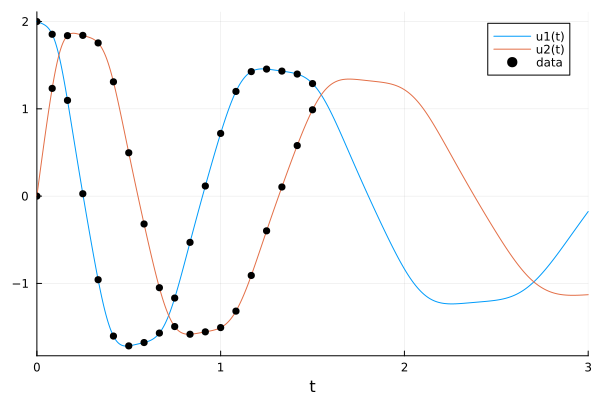

In [2]:
u0 = [2.0; 0.0]
datasize = 19
tspan = (0.0, 3.0)
datatspan = (0.0, 1.5)
datatsteps = range(datatspan[1], datatspan[2]; length=datasize)

function trueODEfunc(u, p, t)
    du = similar(u)
    true_A = [-0.1 2.0; -2.0 -0.1]
    return du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
sol = solve(prob_trueode, Tsit5())
ode_data = Array(sol(datatsteps))

traj = sol(datatsteps);

p = plot(sol)
scatter!(p, datatsteps, ode_data'; markersize=4, color=:black, label=["data" ""])

## Gradient data
For this example we get gradient observations from our trajectory data by interpolating it with a GP and differentiating it.

First, we set all necessary variables, which includes the Multi-Output Kernel and the inputs and outputs.
See also the [KernelFunctions.jl Documentation on Multiple Outputs](https://juliagaussianprocesses.github.io/KernelFunctions.jl/stable/api/#Inputs-for-Multiple-Outputs).

In [3]:
scaker = with_lengthscale(SqExponentialKernel(), 1.0)
moker = IndependentMOKernel(scaker)

x, y = prepare_isotopic_multi_output_data(collect(datatsteps), ColVecs(ode_data))
σ_n = 1e-3
nothing #hide

We define a finite GP

In [4]:
g = GP(moker)
gt = g(x, σ_n)
gt_post = posterior(gt, y)
nothing #hide

Now we use the following convenience functions to a loglikelihood loss function and a function to rebuild the gp with the optimal parameters.
Note that we use optimize over the logarithm of the parameters, to ensure their positivity. For more details see [this KernelFunctions.jl example](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/train-kernel-parameters/)

In [5]:
loss, buildgppost = gp_negloglikelihood(gt, x, y)

p0 = log.([1.0])
unfl(x) = exp.(x)
nothing #hide

Optimizing:

In [6]:
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> (loss ∘ unfl)(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p0)

optp = Optimization.solve(optprob, NelderMead(); maxiters=300)

optparams = unfl(optp)

1-element Vector{Float64}:
 5.305029832442984

Now we can build a FiniteGP with the optimized parameters,

In [7]:
optpost = buildgppost(optparams)
nothing #hide

which fits the data much better than the initial GP:

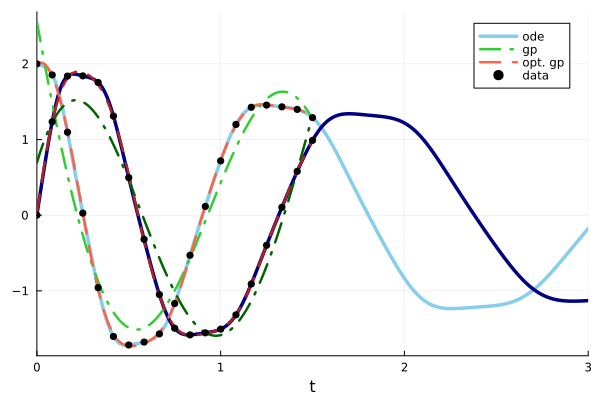

In [8]:
t_plot = range(datatspan...; length=100)
t_plot_mo = MOInput(t_plot, 2)
opt_pred_mean = mean(optpost, t_plot_mo)
opt_pred_mean = reshape(opt_pred_mean, :, 2)
pred_mean = mean(gt_post, t_plot_mo)
pred_mean = reshape(pred_mean, :, 2)
plot(sol; label=["ode" ""], color=[:skyblue :navy], linewidth=3.5)
plot!(
    t_plot,
    pred_mean;
    label=["gp" ""],
    color=[:limegreen :darkgreen],
    linewidth=2.5,
    linestyle=:dashdot,
)
plot!(
    t_plot,
    opt_pred_mean;
    label=["opt. gp" ""],
    color=[:tomato :firebrick],
    linewidth=2.5,
    linestyle=:dash,
)
scatter!(datatsteps, ode_data'; markersize=4, color=:black, label=["data" ""])

GPs are closed under linear operators, which means that we can very easily obtain derivative information along the trajectory.

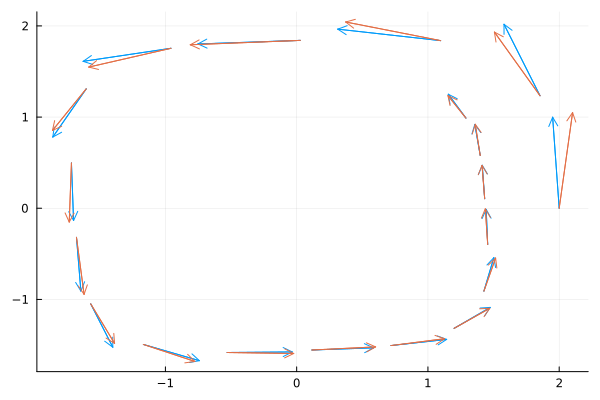

In [9]:
deriv_post = differentiate(optpost)
du_pred_mean = mean(deriv_post, x)
du_pred_mean = reshape_isotopic_multi_output(du_pred_mean, deriv_post)

du = trueODEfunc.(eachcol(ode_data), 0, 0)
sf = maximum(norm.(du))
quiver(
    ode_data[1, :],
    ode_data[2, :];
    quiver=(getindex.(du, 1) / sf, getindex.(du, 2) / sf),
    label="true gradients",
)
quiver!(
    ode_data[1, :],
    ode_data[2, :];
    quiver=(getindex.(du_pred_mean, 1) / sf, getindex.(du_pred_mean, 2) / sf),
    label="predicted gradients",
)

This leaves us with `u` and `udot` pairs as in the input and output for the next GP that will define the ODE.

In [10]:
u = ColVecs(ode_data)
udot = du_pred_mean
nothing #hide

## Building a model
Now we build a model for the the ODE.

In [11]:
scaker = with_lengthscale(SqExponentialKernel(), ones(2))
moker = IndependentMOKernel(scaker)

u_mo, y = prepare_isotopic_multi_output_data(u, udot)
σ_n = 1e-4
nothing #hide

compute the posterior GP

In [12]:
gpfun = GP(moker)
fin_gpfun = gpfun(u_mo, σ_n)
post_gpfun = posterior(fin_gpfun, y)

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByFeatures{SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, KernelFunctions.ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Int64}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}(AbstractGPs.ZeroMean{Float64}(), Independent Multi-Output Kernel
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0)

and optimize its hyperparameters similar as above:

In [13]:
loss, buildgppost = gp_negloglikelihood(fin_gpfun, u_mo, y)

p0 = log.(ones(2))
unfl(x) = exp.(x)

optf = Optimization.OptimizationFunction((x, p) -> (loss ∘ unfl)(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p0)

optp = Optimization.solve(optprob, NelderMead(); maxiters=300)

optparams = unfl(optp)

2-element Vector{Float64}:
 1.5877737044464488
 1.2949407244032454

We build a posterior GP with the optimized parameters,

In [14]:
optpost = buildgppost(optparams)
nothing #hide

and a GP ODE function

In [15]:
gpff = GPODEFunction(optpost)

(::GPDiffEq.PullSolversModule.GPODEFunction{false, AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByFeatures{SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, KernelFunctions.ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Int64}, Vector{Float64}}}}, AbstractGPs.PosteriorGP{GPDiffEq.DerivativeGPModule.DerivativeGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}, AbstractG

Plotting the vector field

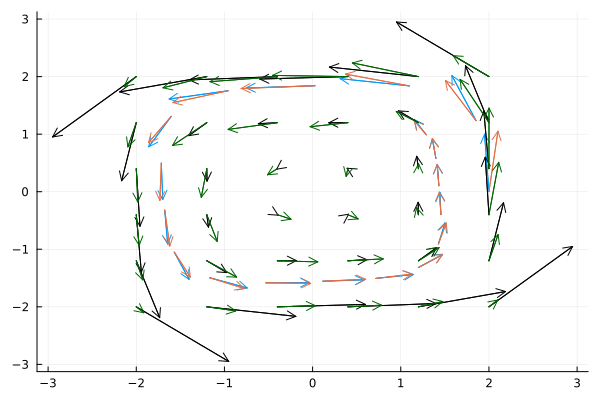

In [16]:
ug = range(-2.0, 2.0; length=6)
ug = vcat.(ug, ug')[:]
gp_pred_mean = gpff.(ug)
true_mean = trueODEfunc.(ug, 0, 0)
quiver!(
    getindex.(ug, 1),
    getindex.(ug, 2);
    quiver=(getindex.(true_mean, 1) / sf, getindex.(true_mean, 2) / sf),
    label="true model",
    color=:black,
)
quiver!(
    getindex.(ug, 1),
    getindex.(ug, 2);
    quiver=(getindex.(gp_pred_mean, 1) / sf, getindex.(gp_pred_mean, 2) / sf),
    label="GP model",
    legend=:bottomright,
    color=:darkgreen,
)

We note that the direction of each gradient corresponds well. However, since the GP mean is zero in the absence of data, in accordance to its prior, the magnitude becomes too small outward from the initial trajectory.
In the center, the GP slightly overestimates the magnitude.

We define a GP ODE model, which can be solved. Initially, the GP ODE corresponds well with the data, but diverges from the true solution as it starts to extrapolate beyond data.

In [17]:
gpprob = GPODEProblem(gpff, u0, tspan)

gpsol = solve(gpprob, PULLEuler(); dt=0.001)
nothing #hide

#### Phase plot

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


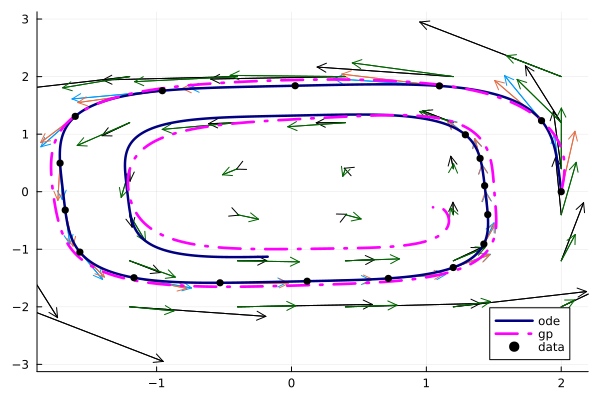

In [18]:
plot!(sol; vars=(1, 2), label="ode", linewidth=2.5, color=:navy)
plot!(
    getindex.(mean.(gpsol.u), 1),
    getindex.(mean.(gpsol.u), 2);
    label="gp",
    linewidth=2.7,
    linestyle=:dashdot,
    color=:magenta,
)
scatter!(ode_data[1, :], ode_data[2, :]; markersize=4, color=:black, label="data")

#### Time Series Plots

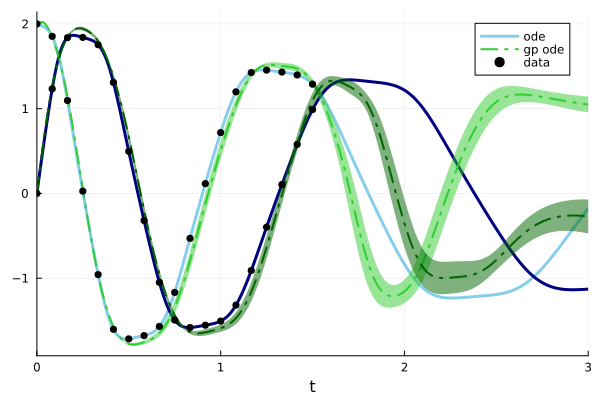

In [19]:
plot(sol; label=["ode" ""], color=[:skyblue :navy], linewidth=3)
plot!(
    gpsol.t,
    reduce(hcat, mean.(gpsol.u))';
    ribbons=sqrt.(reduce(hcat, var.(gpsol.u)))',
    color=[:limegreen :darkgreen],
    linewidth=2,
    linestyle=:dashdot,
    label=["gp ode" ""],
)
scatter!(datatsteps, ode_data'; markersize=4, color=:black, label=["data" ""])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*